# INFO-F-208 - Projet 1 -- Alexandre Heneffe -- 12/10/2018
Ce document "jupyter notebook" nous introduit et nous décrit les différents algorithmes implémentés dans le cadre du Mini Projet 1 du cours "Introduction à la bioinformatique"

## Introduction
Pour ce premier Mini Projet nous traitons la problématique liée à l'alignement de protéines constituées de séquence d'acides aminés représentées par des lettres. 
Les connaissances nécessaires à la compréhension de ce projet sont les bases de la biologie (Notion de protéine, acides aminés). 

Nous procéderons à l'alignement de séquences de protéines mais également de BRD ("Bromo Domain"). 
Les bromodomaines sont des modules interactifs reconnaissant les sites d'acétylation (réactions chimiques) dans les protéines. Les BRD sont notamment intéressantes pour développer de nouvelles thérapies pour le cancer humain ou pour la sclérose en plaques par exemple.

Les acides aminés ont évolué au fil du temps, ce qui a induit des modifications (insertions, suppressions, substitutions). De ce fait, nous cherchons à les aligner de sorte à trouver leurs similitudes maximales dissimulées et déterminer si celles-ci sont homologues (2 gènes ou 2 protéines qui partagent un ancêtre commun).

Notre objectif est d’implémenter les algorithmes de Needleman-Wunsch et de Smith-Waterman qui trouveront respectivement les alignements globaux et les alignements locaux et permettront d'analyser les similitudes. Ces notions seront détaillées plus tard.


## Matériel 

Nous allons maintenant aborder l'implémentation des ADT "Abstract Data Type" permettant de créer des outils utiles à l'implémentation des algorithmes.


In [1]:
import copy as c
import pandas

pandas.set_option('display.max_columns', 500)

### ADT Séquence

Avec cette classe, nous créons des objets représentant des Séquences. Nous pouvons l'afficher au format FASTA pour visualiser son nom et ses acides aminées par exemple.

In [2]:
class Sequence:
    """ 
    Classe qui représente un objet Séquence d'acides aminées 
    """

    def __init__(self, title = None, seq = None):
        """ Crée un objet Séquence """

        if title != None and seq != None:
            self.__seq = seq # Séquence : string
            self.__title = title #Titre de la séquence

    def get_acids(self):
        """ Renvoie les lettres de la séquence """
        return self.__seq 

    def length(self):
        """ Renvoie la taille de la séquence """
        return len(self.__seq)

    def set_title(self, title):
        """ Donne un nom a la séquence """
        self.__title = title 
    
    def set_seq(self, seq):
        """ met à jour la séquence """
        self.__seq = seq 

    def display(self):
        """ Affiche la séquence au format FASTA """
        print(self.__title)
        print(self.__seq, end="\n\n")
        
        
print("Exemple de séquence: ", end= 2*"\n")
ExempleSeq = Sequence("sp|O60885|75-147", "WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFT\
NCYIYNKPGDDIV")
ExempleSeq.display()



Exemple de séquence: 

sp|O60885|75-147
WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIV




### ADT Parser de séquence(s)

Nous utilisons le parser de séquence(s) afin de récupérer les séquences d'acides aminées ainsi que leurs noms depuis un fichier au format FASTA (succession de séquences précédées par leurs noms). Nous créons ensuite une liste d'objets Séquence à partir des données fournies que nous pourrons utiliser dans les algorithmes décrits plus tard.

In [3]:
class ParserSequence:
    """ 
    Classe qui représente un Parser qui va lire un fichier avec des séquences
    """

    def __init__(self, file_name):
        """ Crée un objet Parser """

        self.lines = open(file_name, "r").readlines()  #Lignes du fichier
        self.nb_lines = len(self.lines)
        self.sequences = [] #Liste d'objets Séquence

    def create_seq(self, seq, title):
        """ Ajoute une séquence a la liste de séquences """

        new_S = Sequence()   # Crée un nouvel objet Séquence
        new_S.set_seq(seq)   # lui donne la séquence correspondante
        new_S.set_title(title) # titre de la séquence

        self.sequences.append(new_S) #ajout d'un nouvel objet séquence

    def get_seq(self, i):
        """ Renvoie une séquence de la liste """
        return self.sequences[i]
        
    def parse(self):        
        """ Récupère les séquences du fichier """

        tmp = ""
        title = ""
        for line in self.lines: # lignes du fichier
            if line[0] == ">":
                # print(tmp + "\n")
                if tmp != "":    
                    self.create_seq(tmp, title)    # on crée un objet séquence          
                    tmp = ""

                title = line
            else:
                tmp += line.strip("\n")

        self.create_seq(tmp, title)

### ADT Matrice

Afin d'aligner les séquences d'acides aminées, nous utilisons des objets représentant des matrices. Les différents types de matrice qui dérivent de cet objet Matrice seront décrits après (matrice de substitution, de scoring, V, W).

In [4]:
class Matrix:
    """ 
    Classe qui représente un objet Matrice 
    """

    def __init__(self):
        """ Crée un objet Matrice """

        self.mat = []
        self.n = 0 # colonnes (seq1)
        self.m = 0 # lignes (seq2)
        self.letters_seq1 = {} # dictionnaire clé = lettre, valeur = indice dans matrice
        self.letters_seq2 = {}  #     "
        self.letters_orders1 = "" #Les lettres des colonnes mis dans l'ordre 
        self.letters_orders2 = "" #Les lettres des lignes mis dans l'ordre


    def get_acid_score(self, i, j):
        """ Renvoie le score d'une cellule représentée par 2 lettres """
        if i == "-" or j == "-":
            return -1
        else:
            return self.mat[self.letters_seq1[i]][self.letters_seq2[j]]

    def get_score(self, i, j):
        """ Renvoie le score d'une cellule en mat[i][j] """
        return self.mat[i][j]

    def set_score(self, i, j, score):
        """ donne un score a une cellule """
        self.mat[i][j] = score

    def addline(self):
        """ ajoute une ligne dans la matrice """
        self.mat.append([])
        self.m += 1

    def add_cell(self, i, score):
        """ ajoute un élément dans une ligne (score) """
        if isinstance(score, str):
            score = int(score)

        self.mat[i].append(score)

    def set_lign(self, scores):
        """ ajoute toute une ligne avec des scores """
        self.mat.append(scores)

    def inc_nb_col(self):
        """ augmente le nb de colonnes de 1 """
        self.n += 1

    def set_nb_col(self):
        """ détermine le nombre de colonnes """
        self.n = len(self.mat[0])

    def inc_nb_lign(self):
        """ augmente le nb de lignes de 1 """
        self.m += 1    


La matrice est déterminée par 2 séquences de lettres. Nous définissons un structure de la forme:

$$ \{ "A": 0, "B": 1, "C": 2, ... \}$$ 

Cela nous permettra de récupérer le score d'une paire d'acides aminés à partir de leurs lettres. Dans notre cas, ce sera pour récupérer des scores figurant dans la matrice de substitution.

In [5]:
def get_letters(self, i, j):
    """ Renvoie les lettres correspondantes a la cellule i,j """
    return self.letters_orders2[i] + self.letters_orders1[j]

def set_letters_seq(self, seq1, seq2):
    """ remplit les dictionnaires par
        clé : acide aminée, valeur : indice dans la matrice
    """

    seq1 = seq1.replace(" ", "")
    seq2 = seq2.replace(" ", "")
    self.letters_orders1 = seq1
    self.letters_orders2 = seq2

    self.letters_seq1 = dict(zip(seq1, (i for i in range(len(seq1)))))
    self.letters_seq2 = dict(zip(seq2, (i for i in range(len(seq2)))))  
    
Matrix.get_letters = get_letters
Matrix.set_letters_seq = set_letters_seq

Pour visualiser les matrices tout au long des algorithmes, nous les affichons de manière jolie à l'aide de la méthode ci-dessous.

In [6]:
def display(self):
    """ Affiche la matrice """

    for l in self.letters_orders1:
        if l == "-":
            print("\t-", end="\t")
        else:
            print(l, end= "\t")
    print("\n")

    for i in range(self.m): # lignes
        print(self.letters_orders2[i], end ="\t")
        if self.letters_orders2[i] == "-":
            #print("  ", end= "")
            pass
        for j in range(self.n): # colonne
            print(self.mat[i][j], end= "\t")
        print("\n")
    print("\n") 

Matrix.display = display

def panda(self):
    """ Autre moyen d'afficher la matrice de manière plus compacte """
    
    print(pandas.DataFrame(self.mat, list(self.letters_orders2), \
    pandas.Index(list(self.letters_orders1), name="*")), end="\n\n")

Matrix.panda = panda
        

### ADT Matrice de substitution

La matrice de substitution nous donne le score de similarité de chaque paire d'acides aminés. 

Lorsque 2 acides aminés se substituent, l'évolution accepte ou non le remplacement selon la préservation de la stabilité de la protéine et la modification de leurs foncionnalités biochimiques. Le score de similarité nous donne une idée de ces remplacements en nous donnant la probabilité que les 2 acides aminés soient homologues et la probabilité qu'ils soient liées de façon stochastique. Un score positif montre les mutations acceptées et un score négatif montre les mutations refusées.

Nous avons à notre disposition les matrices de substitution "BLOSUM62", "BLOSUM80", "PAM120 et "PAM60" dont les scores ont été calculés sur base de l'homologie de différentes espèces. Les différents types de matrices "PAM" montrent une différence dans le nombre de substitutions acceptées, donc la divergence entre les séquences tandis que les différents types de "BLOSUM" sont dues a une variation du pourcentage d'identité entre les séquences.


In [7]:
class MatSubstitution(Matrix):
    """ 
    Classe qui représente un Parser qui va lire un fichier avec une matrice
    de substitution
    Cette classe hérite de Matrix
    """

    def __init__(self, file_name):
        """ Crée un objet Parser """

        Matrix.__init__(self) 
        self.lines = open(file_name, "r").readlines()  #Lignes du fichier
        self.nb_lines = len(self.lines)

    def get_mat_sub(self):
        """ Renvoie la matrice de subsitution parsée """

        return self.mat         
    

### ADT Parser de matrice

Nous utilisons le parser de matrice pour récupérer une matrice de substitution contenue dans un fichier et la placer dans un objet "Matrice" sur lequel nous pouvons appliquer différentes fonctions (tel que l'afficher, obtenir l'information d'une cellule, ajouter des éléments, etc..) . Nous nous servirons des scores de cette matrice de substitution lors de la détermination des alignements de séquences d'acides aminées. 

In [8]:
def parse(self):        
    """ Récupère la matrice du fichier """

    i = 0
    for line in self.lines: # lignes du fichier

        line = line.strip("\n")
        if len(line) > 0:
            if line[0] == " ":
                self.set_letters_seq(line, line)   # lettres de seq 1 et 2
            else:
                if line[0] != "#":
                    self.addline()
                    all_line = line.split(" ")
                    for l in all_line:
                        if l != "" and not l.isalpha() and l != "*":
                            self.add_cell(i, l)
                    i += 1

    self.set_nb_col() 
        
MatSubstitution.parse = parse

print("Matrice de substitution BLOSUM62: \n\n")
subEx = MatSubstitution("blosum62.txt")
subEx.parse()
#subEx.display()
subEx.panda()


Matrice de substitution BLOSUM62: 


*  A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T   W  Y  V  B  Z  X  *
A  4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0  -3 -2  0 -2 -1  0 -4
R -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1  -3 -2 -3 -1  0 -1 -4
N -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0  -4 -2 -3  3  0 -1 -4
D -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1  -4 -3 -3  4  1 -1 -4
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1  -2 -2 -1 -3 -3 -2 -4
Q -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1  -2 -1 -2  0  3 -1 -4
E -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1  -3 -2 -2  1  4 -1 -4
G  0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2  -2 -3 -3 -1 -2 -1 -4
H -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2  -2  2 -3  0  0 -1 -4
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1  -3 -1  3 -3 -3 -1 -4
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1  -2 -1  1 -4 -3 -1 -4
K -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1  -3 -2 -2 

### ADT Matrice de Scoring 

Nous avons une classe qui permet de créer une matrice de scoring et de l'initialiser selon la méthode. Si nous sommes dans un alignement global, nous initialisons la matrice avec les pénalités d'ouverture de gap "I" et de continuité de gap "E". La notion de "gap" sera détaillée plus tard.

In [9]:
class MatScoring(Matrix):
    """ Classe qui représente une matrice contenant les scores avec une pénalité
        de gap affine
        Cette classe hérite de Matrix
    """ 

    def __init__(self, I, E, n, m):
        Matrix.__init__(self)

        self.n = n 
        self.m = m 
        self.I = I
        self.E = E 

    def init_S_global(self):
        """ Initialise 1ere ligne et 1ere colonne de S pour la méthode globale """

        first_col = [0]
        for i in range(self.m):

            newline = []
            if i == 0:
                newline += [0, -self.I]    # 1ere ligne [0, -I, -I-E, ...]
                for j in range(2, self.n):
                    newline.append(newline[j-1] - self.E)
                

            elif i == 1:
                newline += [-self.I] + (self.n-1)*[""]
                first_col += [-self.I]
            else:
                first_col.append(first_col[i-1] - self.E)
                newline += [first_col[i]] + (self.n-1)*[""]
                
            self.set_lign(newline)
            
# =================================== EXEMPLE ========================================
ExempleS = MatScoring(4, 2, 5, 4)
ExempleS.init_S_global()
ExempleS.set_letters_seq("-ABCD", "-EFGH")
print("Exemple de matrice de scoring initialisée pour l'alignement global: ", end=2*"\n")
ExempleS.display()

Exemple de matrice de scoring initialisée pour l'alignement global: 

	-	A	B	C	D	

-	0	-4	-6	-8	-10	

E	-4					

F	-6					

G	-8					





### ADT Matrices V et W
Nous pouvons créer des matrices V et W permettant de sauvegarder les informations concernant les gap lors du calcul de la matrice de scoring. Nous les initialisons avec des valeurs infinies - Inf sur la première ligne de V et des 0 sur la première colonne de V. Nous procédons de la même manière pour W mais en inversant les valeurs -Inf et 0.

$$
V = \begin{bmatrix} -Inf & -Inf & ... \\ 0 \\ 0\\ ... \end{bmatrix}  W = \begin{bmatrix} 0 & 0 & ... \\ -Inf \\ -Inf\\ ... \end{bmatrix} 
$$

In [10]:
class MatV(Matrix):
    """ Classe qui représente une matrice permettant de sauvegarder des valeurs 
        liées aux lignes lors du calcul de la matrice de scoring 
        Cette classe hérite de Matrix
    """

    def __init__(self, n, m):
        Matrix.__init__(self)

        self.n = n 
        self.m = m 

    def init_V(self):
        """ Initialise 1ere ligne et 1ere colonne de V """

        for i in range(self.m):
            if i == 0:
                self.set_lign([-float("inf")]*self.n) # -inf -inf -inf ...
            else:
                self.set_lign([0] + (self.n-1)*[""]) # 0 ...

In [11]:
class MatW(Matrix):
    """ Classe qui représente une matrice permettant de sauvegarder des valeurs 
        liées aux colonnes lors du calcul de la matrice de scoring 
        Cette classe hérite de Matrix
    """

    def __init__(self, n, m):
        Matrix.__init__(self)

        self.n = n
        self.m = m 

    def init_W(self):
        """ Initialise 1ere ligne et 1ere colonne de W """

        for i in range(self.m):
            if i == 0:
                self.set_lign([-float("inf")] + [0]*(self.n-1)) # -inf 0 0 0 0 ...
            else:
                self.set_lign([-float("inf")] + (self.n-1)*[""]) # 0 ... 

## Méthodes

Maintenant, nous allons parler de la méthodologie utilisée pour produire des résultats corrects.

### Objectif

Ce que nous cherchons à obtenir à l'aide de la programmation dynamique et les algorithmes, ce sont des solutions de cette forme :

In [12]:
print("MGGETFA\n :: :  \n-GGVTTF")

MGGETFA
 :: :  
-GGVTTF


Ceci est un exemple d'alignement de 2 séquences d'acides aminées. 

Nous introduisons la notion de "gap". Celui-ci est un espace dans la séquence qui est représenté par un "-". Il sert à procéder à une insertion ou à une suppression. Dans l'exemple ci-dessus, l'élement "M" de la première séquence est supprimé dans la deuxieme séquence. Cela permet de ne garder que les similitudes entre les 2 séquences.

De plus, étant donné que nous utilisons un système de scores pour procéder à ces alignements de séquences, et que les gaps diminuent les pourcentages de similarité entre 2 séquences, nous leur donnons un score de pénalité. 

Dans le cadre de ce projet, nous utiliserons une pénalité de gap affine et non linéaire:

- Une pénalité linéaire est une valeur négative identique pour tous les gaps
- Avec une pénalité affine, une ouverture de gap est plus pénalisante qu'une continuité de gap:

$$ ABC----DF $$

Par exemple, le premier gap aura une pénalité de -4 (I) et ceux qui suivent auront une pénalité de -1 (E).

### Programmation dynamique

Le meilleur moyen de trouver les alignements optimaux est la programmation dynamique. En effet, dans une approche de "Diviser pour régner", un résultat à l'instant t est déterminé par un résultat à l'instant t-1. Si nous devions calculer toutes les combinaisons possibles entre les 2 séquences d'aminées, le temps de calcul serait énorme. A la place, à chaque étape, nous utilisons les résultats précédemment calculés. 

Notre problème possède les 2 caractéristiques représentatives d'un problème devant être résolu par de la programmation dynamique: 

- Le problème contient des solutions optimales pour les sous-problèmes du problème global: nous retenons les valeurs V(i,j) et W(i,j) à chaque étape et S(i,j) détermine un sous-alignement de séquences optimales seq1[j:] et seq[i:] (des sous-séquences).

- La solution récursive contient un nombre limité de sous-problèmes distincts répétés beaucoup de fois: Lors du backtracking, nous construisons d'abord la solution optimale de taille minimale (en bas à droite) et puis nous construisons de manière croissante les solutions optimales des sous-problèmes en remontant vers le coin en haut à gauche.



Notre cas ressemble fortement à un problème de recherche de distance d'édition "D" entre 2 chaînes de caractères (Nombre minimum d'opérations d'insertion, suppression, remplacement pour passer d'une chaine à une autre). 

En effet, 2 caractères différents dans un alignement de séquence représentent un remplacement, un espace dans la première séquence représente une insertion dans la seconde et un espace dans la seconde séquence représente une suppression dans la première séquence.


il possède également les 2 caractéristiques d'un problème dynamique et réalise une solution récursive de la forme:

$$D(i,j) = \left\{ \begin{array}{ll} i & \mbox{si } \{i>0, j=0\} \\ j & \mbox{si } \{i=0, j>0\} \\ 
       min(D(i-1, j) + 1, D(i, j-1) + 1, D(i-1, j-1) + t(i, j)  )
    \end{array} \right.$$
    
similaire à celle de l'alignement de séquence (détaillé plus tard)


### Alignement

Nous définissons un objet Alignement qui représente un alignement de séquence de manière générale. Celui-ci se décline en 2 types d'Alignements: 
- L'alignement global
- L'alignement local 

Tous les 2 ont des algorithmes différents mais similaires d'un point de vue technique. L'alignement général va simplement initialiser les séquences de séquences d'acides aminés, les matrices de substitution, de scoring, les matrices de sauvegarde V et W pour les alignements globaux ou locaux. 

In [13]:
class Alignment:
    """ Classe représentant un objet qui trouvera l'alignement de 2 séquences
        d'acides aminées
    """

    def __init__(self, I, E, mat_file, seq1, seq2, p):
        
        self.I = I 
        self.E = E
        self.p = p
        self.seq1 = seq1
        self.seq2 = seq2
        self.n = self.seq1.length()+1
        self.m = self.seq2.length()+1

        if self.p == 1 or p == 2: # Si on veut imprimer les informations
            print("Séquence 1 de longueur {0}: ".format(self.n))
            self.seq1.display() 
            print("Séquence 2 de longueur {0}: ".format(self.m))
            self.seq2.display()
            print("matrice de substitution utilisée: {0}".format(mat_file))
            print("Pénalité de gap affine: I = {0} | E = {1}".format(self.I, self.E))

        # =================== SUBSITUTION ==============================
        self.t = MatSubstitution(mat_file)
        self.t.parse()

        # =================== SCORING ===============================

        self.S = MatScoring(I, E, self.n, self.m) 
        # on crée un objet matrice de scoring

        # ===================== V ET W ===================================

        self.V = MatV(self.n, self.m)
        self.W = MatW(self.n, self.m)

        self.V.init_V() # Initialise V
        self.V.set_letters_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())
        self.W.init_W() # Initialise W
        self.W.set_letters_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())

        self.current_sol = [] # Pour le backtracking
        self.all_solutions = []

    def get_v(self, i, j):
        return max( self.S.get_score(i-1, j) - self.I, 
                    self.V.get_score(i-1,j) - self.E )

    def get_w(self, i, j):
        return max( self.S.get_score(i, j-1) - self.I,
                    self.W.get_score(i, j-1) - self.E )

#### Alignement global

L'alignement global va utiliser l'algorithme de Needleman et Wunsch (implémentée ci-dessous dans la classe Alignement Global). Celui-ci va chercher l'alignement qui donne la plus grande similarité entre 2 séquences d'acides aminées.

Tout d'abord, Nous devons initialiser la matrice de scoring avec une pénalité de gap affine. Comme décrit plus haut, la matrice initiale aura la forme:


$$
S = \begin{bmatrix} 0 & -I & -I-E & -I-E-E & .. \\ -I \\ -I-E \\ -I-E-E \\ ... \end{bmatrix} 
$$



Ensuite, nous calculons le reste des cellules de cette matrice:

Etant donné que des gaps sont introduits dans les 2 séquences, il faut sauvegarder l'état de ces gaps dans des matrices V et W préalablement initialisée comme décrit plus haut.

- Première séquence (les colonnes:
    - Si la valeur précédente N'était PAS un gap, on utilise S(i - 1, j) - la pénalité de gap d'ouverture I
    - Si la valeur précédente ETAIT un gap, on utilise V(i - 1, j) - la pénalité de gap de continuité E
    
    $$V(i,j) = max\left\{ \begin{array}{ll} S(i - 1, j) - I \\ V(i - 1, j) - E
    \end{array} \right.$$
    
- Deuxième séquence (les lignes):
    - Si la valeur précédente N'était PAS un gap, on utilise S(i, j - 1) - la pénalité de gap d'ouverture I
    - Si la valeur précédente ETAIT un gap, on utilise W(i, j - 1) - la pénalité de gap de continuité E
    
    $$W(i,j) = max\left\{ \begin{array}{ll} S(i, j - 1) - I \\ W(i, j - 1) - E
    \end{array} \right.$$

La cellule S(i,j) de la matrice de scoring devient alors: 

$$S(i,j) = max\left\{ \begin{array}{ll} S(i - 1, j - 1) + MatSubstitution(i, j) \\
        V(i, j) \\ W(i, j) \end{array} \right.$$
    

In [14]:
class GlobalAlignment(Alignment):
    """
    Classe qui va trouver un aligement de séquences d'acides aminées avec
    une pénalité affine et une méthode globale
    """

    def __init__(self, k, I, E, mat_file, seq1, seq2, p):
        Alignment.__init__(self, I, E, mat_file, seq1, seq2, p)
        self.k = k

        self.S.init_S_global()  # On initialise la matrice de scoring
        self.S.set_letters_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())

    def update_s_global(self, i, j, v_ij, w_ij):
        letters_ij = self.S.get_letters(i,j) # 'AB' par exemple
        t_ij = self.t.get_acid_score(letters_ij[0], letters_ij[1])

        s_ij = max( self.S.get_score(i-1,j-1) + t_ij, v_ij, w_ij )
        self.S.set_score(i,j, s_ij)

    def Needleman_Wunsch(self):
        """ 
        Algorithme qui calcule la matrice de scoring pour l’alignement global 
        en utilisant la pénalité affine puis fait un backtracking pour récupérer
        tous les alignements optimaux possibles
        """

        # ==================== CREATION SCORING ===========================

        for i in range(1, self.m):
            for j in range(1, self.n):
                v_ij = self.get_v(i, j)   # V(i,j)
                self.V.set_score(i,j, v_ij)
                w_ij = self.get_w(i, j)
                self.W.set_score(i,j, w_ij) # W(i,j)

                self.update_s_global(i, j, v_ij, w_ij)

        if self.p == 2: # Si on veut afficher les matrices
            self.V.display()
            self.W.display()
            self.S.panda()

        self.current_sol.append((self.m-1, self.n-1)) 
        self.backtracking_global(self.m-1, self.n-1) #appel sur element en derniere
                                                     #ligne, derniere colonne

        
        R = Result(self.S, self.t, self.all_solutions, self.p)
        res = R.compute_result()
        return res

#### backtracking

Une fois la matrice de scoring créée, il faut utiliser un backtracking.
Le backtracking est une méthode algorithmique permettant de trouver toutes les solutions optimales d'un problème de manière récursive. Il construit une solution petit à petit selon certaines conditions. Une fois qu'il a trouvé une solution admissible, il détruit la solution et en crée une nouvelle. C'est une approche "BOTTOM-UP".

Dans notre cas, le backtracking part du dernier élément de la matrice de scoring (en bas à droite) et va remonter vers l'élément en (0,0). Une solution est donc un chemin partant du dernier élément jusqu'au premier élément.

        
A chaque étape nous avons 3 possibilités: $$  \begin{bmatrix} S(i-1,j-1)+t(i,j) & V(i,j) \\ W(i,j) & S(i,j) \end{bmatrix} $$

Etant donné que S(i,j) est calculée à partir de V, W, et de l'élément en diagonale + le score de la matrice de substitution, il revient sur la cellule ayant le score maximal de ces 3 éléments.

La méthode ci-dessous réalise ce backtracking:


In [15]:
def backtracking_global(self, i, j):
    """ Remonte la matrice de scoring a partir du dernier élément jusqu'à [0][0]
        pour avoir les k alignements
    """

    if i == 0 or j == 0:
        if i == 0 and j == 0:
            if len(self.current_sol) > 0:
                self.current_sol.pop() # Si on est en (0,0)
        if len(self.all_solutions) == self.k: # Si on a deja trouvé k alignements
            return 
        if self.current_sol not in self.all_solutions:
            #print("1 solution trouvé: ", self.current_sol)
            self.all_solutions.append(c.deepcopy(self.current_sol))           

    else:
        for pos in range(3):

            new_i = i 
            new_j = j 
            valid = False 
            if pos == 0 and self.is_previous("v", i, j):  # haut
                new_i -= 1 # i-1
                valid = True 
            elif pos == 1 and self.is_previous("w", i, j): # gauche
                new_j -= 1 # j-1  
                valid = True 
            elif pos == 2 and self.is_previous("s", i, j): # diagonale
                new_i -= 1 # i - 1
                new_j -= 1  # j - 1
                valid = True 

            if valid: 
                self.current_sol.append((new_i, new_j))
                self.backtracking_global(new_i, new_j) # appel sur cellule suivante
                if len(self.current_sol) != 0:
                    self.current_sol.pop() # destruction sol partielle

GlobalAlignment.backtracking_global = backtracking_global

La méthode is_previous (ci-dessous) permet à tout moment lors du backtracking de vérifier vers quelle cellule il doit se diriger:
- Si l'élément S(i,j) est déterminé par V(i,j), il se dirige vers la cellule du dessus
- Si l'élément S(i,j) est déterminé par W(i,j), il se dirige vers la cellule de gauche 
Ces deux éléments introduisent alors des gap dans la solution
- SI l'élement S(i,j) est déterminé par S(i-1, j-1) + son score de substitution, il se dirige en diagonale en haut à gauche de lui.

$$  \begin{bmatrix} S(i-1,j-1)+t(i,j) & V(i,j) \\ W(i,j) & S(i,j) \end{bmatrix} $$

In [16]:
def is_previous(self, mat, i, j):
    """ Regarde si l'élement ij résulte de l'élément en diagonale,
        en haut ou a gauche 
    """

    res = False
    if mat == "v":
        if self.V.get_score(i,j) == self.S.get_score(i,j):
            res = True 

    elif mat == "w":
        if self.W.get_score(i,j) == self.S.get_score(i,j):
            res = True 

    elif mat == "s":
        letters_ij = self.S.get_letters(i,j) # 'AB' par exemple
        t_ij = self.t.get_acid_score(letters_ij[0], letters_ij[1])  # t(i,j)

        if self.S.get_score(i-1, j-1) + t_ij == self.S.get_score(i,j):
            res = True 

    return res 

Alignment.is_previous = is_previous


#### Alignement local

L'alignement local va utiliser l'algorithme de Smith-Waterman. Nous voulons trouver les morceaux de séquences similaires. Cet algorithme utilise également la programmation dynamique et ressemble à l'algorithme de Needleman-Wunsch. 

In [17]:
class LocalAlignment(Alignment):
    """
    Classe qui qui va trouver un aligement de séquences d'acides aminées avec
    une pénalité affine et une méthode locale
    """

    def __init__(self, l, I, E, mat_file, seq1, seq2, p):
        Alignment.__init__(self, I, E, mat_file, seq1, seq2, p)
        self.l = l

        self.S.init_S_local()  # On initialise la matrice de scoring
        self.S.set_letters_seq("-"+self.seq1.get_acids(), "-"+self.seq2.get_acids())

        self.zeros = []
        self.found = False

    def update_s_local(self, i, j, v_ij, w_ij):
        """ détermine la valeur de S en fonction de V et W et de t"""

        letters_ij = self.S.get_letters(i,j) # 'AB' par exemple
        t_ij = self.t.get_acid_score(letters_ij[0], letters_ij[1])
        s_ij = max( self.S.get_score(i-1,j-1) + t_ij, v_ij, w_ij, 0 )
        self.S.set_score(i,j, s_ij)    

    

Tout d'abord, nous initialisons les matrices V, W et S. V et W sont de la meme forme que ceux utilisés pour l'alignement global: 

$$
V = \begin{bmatrix} -Inf & -Inf & ... \\ 0 \\ 0\\ ... \end{bmatrix}  W = \begin{bmatrix} 0 & 0 & ... \\ -Inf \\ -Inf\\ ... \end{bmatrix} 
$$

La matrice de scoring ne contiendra que des valeurs positives ou nulles. Si nous obtenons un score négatif, celui-ci devient 0. De ce fait, la matrice est initialisée de cette manière:

$$
S = \begin{bmatrix} 0 & 0 & 0 & ... \\ 0 \\ 0\\ ... \end{bmatrix} 
$$

La méthode ci-dessous réalise cette initialisation:

In [18]:
def init_S_local(self):
    """ Initialise 1ere ligne et 1ere colonne de S pour la méthode locale """

    for i in range(self.m):
        newline = []
        if i == 0:
            newline += [0]*self.n 
        else:
            newline += [0] + (self.n-1)*[""]

        self.set_lign(newline)
        
MatScoring.init_S_local = init_S_local

Une fois les matrices V, W et S initialisée, nous les calculons à l'aide de ces relations:

$$V(i,j) = max\left\{ \begin{array}{ll} S(i - 1, j) - I \\ V(i - 1, j) - E
    \end{array} \right.$$

$$W(i,j) = max\left\{ \begin{array}{ll} S(i, j - 1) - I \\ W(i, j - 1) - E
    \end{array} \right.$$

$$S(i,j) = max\left\{ \begin{array}{ll} S(i - 1, j - 1) + MatSubstitution(i, j) \\
        V(i, j) \\ W(i, j) \\ 0 \end{array} \right.$$
        
Ceci est réalisé par la méthode ci-dessous:

In [19]:
def compute_scoring(self, start_i, start_j):
    """ ReCalcule la matrice de
    scoring pour les alignements locaux  avec pénalité affine 
    après avoir trouvé un alignement local
    """

    # ==================== CREATION SCORING ===========================

    for i in range(start_i, self.m):
        for j in range(start_j, self.n):
            if (i,j) not in self.zeros:
                v_ij = self.get_v(i, j)     # V(i,j)
                self.V.set_score(i,j, v_ij)
                w_ij = self.get_w(i, j)     # W(i,j)
                self.W.set_score(i,j, w_ij)

                self.update_s_local(i, j, v_ij, w_ij)

    if self.p == 2:
        print("la matrice de Scoring: ")
        self.S.panda()
    
LocalAlignment.compute_scoring = compute_scoring

Une fois la matrice de scoring, ainsi que les matrices de sauvegarde V et W sont calculées, nous cherchons la cellule dont le score est maximal. Nous utiliserons la méthode prédéfinie ci-dessous:

In [20]:
def get_max(self):
    """ Renvoie la position de l'élément maximal de la matrice """

    maxi = -float("inf") # - inf 
    i, j = 0, 0
    for line in range(self.m):
        current_max = max(self.mat[line])
        if current_max > maxi:
            maxi = current_max
            i = line 
            j = self.mat[line].index(current_max)

    return (i,j)
        
Matrix.get_max = get_max

Depuis ce maximum, nous réalisons un backtracking qui ne recherche qu'une solution. Celui-ci part donc de la cellule dont le score est maximal et remonte selon les mêmes conditions que l'alignement global. 
- Si contre, la cellule S(i,j) a été déterminé par le 0 lors du calcul du maximum (voir relations ci-dessus), nous nous arrêtons. 
- Si il ne rencontre pas de 0, il s'arrête lorsqu'il se trouve sur la première ligne ou sur la première colonne de la matrice score.

Cette approche "bottom-up" est mise en oeuvre par les méthodes ci-dessous:

In [21]:
def sol_found(self, i,j):
    """ Détermine si on a fini un alignement local """

    return (i == 0 or j == 0 or self.S.get_score(i,j) == 0)

LocalAlignment.sol_found = sol_found

def bottom_up(self, i,j):
    """ Remonte la matrice de scoring a partir du max de la matrice
        de scoring jusqu'à un élément de la 1ere ligne ou 1ere colonne
        ou un élément 0
    """
    self.current_sol.append((i,j))
    while not self.sol_found(i,j):
        if self.is_previous("v", i, j):    # haut
            i-=1
        elif self.is_previous("w", i, j):  # gauche
            j-=1
        elif self.is_previous("s", i, j):  # diagonale
            i-=1
            j-=1
        if self.S.get_score(i,j) != 0:
            self.current_sol.append((i,j))

    self.all_solutions.append(self.current_sol)
    self.zeros += self.current_sol
    self.current_sol = []
    
LocalAlignment.bottom_up = bottom_up

Après avoir enregistré la solution (le chemin), nous mettons les éléments sur lesquels nous sommes passés à 0.

In [22]:
def set_zero(self, positions):
    """ Met à 0 les éléments donnés en paramètre dans la matrice """

    for pos in positions:
        self.mat[pos[0]][pos[1]] = 0

Matrix.set_zero = set_zero 

Enfin, étant donné que nous souhaitons connaître un certain nombre de solution, il nous faut répéter ce processus. Pour résumer, l'algorithme Smith-Waterman ci-dessous va réaliser les actions suivantes: <br>
Tant que l'on n'a pas trouvé k solutions:

- Trouver la cellule ayant le score maximal de la matrice de scoring préalablement calculée
- Procéder à un "bottom up" pour trouver le chemin correspondant et en s'arrêtant soit en ayant rencontré un 0, soit en étant sur la première ligne ou la première colonne
- Mettre à 0 ce nouveau chemin dans la matrice de scoring et dans les matrices V et W
- Recalculer les 3 matrices S, V et W en tenant compte des 0 mis en place précédemment.

In [23]:
def Smith_Waterman(self):
    self.compute_scoring(1,1)

    for i in range(self.l):
        current_max = self.S.get_max()
        self.bottom_up(current_max[0], current_max[1])
        if i == self.l-1: # Si on a trouvé l solutions
            break
        # une fois le backtrack fini, on met a 0 l'alignement 
        self.S.set_zero(self.all_solutions[-1])
        self.V.set_zero(self.all_solutions[-1])
        self.W.set_zero(self.all_solutions[-1])
        if self.p == 2:
            print("mise a 0: ")
            self.S.panda()

            print("recalcul de la matrice: ")
        print(self.all_solutions[-1][-1][0], " ",
                             self.all_solutions[-1][-1][1])
        self.compute_scoring(self.all_solutions[-1][-1][0], \
                             self.all_solutions[-1][-1][1])

    R = Result(self.S, self.t, self.all_solutions, self.p)
    return R.compute_result()
    
LocalAlignment.Smith_Waterman = Smith_Waterman

## Résultats & Discussion

### ADT Resultat

Cette classe nous permet de mettre en place la solution calculée grâce aux algorithmes. Elle va d'abord rassembler les paires d'acides aminées en instaurant des gap selon les conditions décrites plus haut (sur base des matrices V et W).

In [24]:
class Result:
    """ Classe représentant un objet Résultat dans laquelle on va aligner
        2 séquences selon la matrice de scoring obtenue
    """

    def __init__(self, S, t, all_sol, p):
        self.S = S  # matrice de scoring 
        self.t = t # matrice de substitution
        self.all_solutions = all_sol
        self.gap = "-"
        self.p = p # Pour savoir si on veut print le résultat ou non
        
    def compute_result(self):
        """ trouve les correspondances entre lettres de l'alignement """
        
        scores_sim = [] # stocke le score de similarité des résultats

        for sol in self.all_solutions:
            used = {} # dictionnaire avec indices deja utilisés 
                    # clé = colonnes, valeur = lignes
            res = []
            for pos in range(len(sol)-1, -1, -1):
                
                letters = self.S.get_letters(sol[pos][0], sol[pos][1])
                score = self.t.get_acid_score(letters[0], letters[1])
                if sol[pos][0] in used.values():
                    letters = self.gap + letters[1] # '-B' par ex
                if sol[pos][1] in used.keys():
                    letters = letters[0] + self.gap # 'B-' par ex

                res.append((letters, score)) # On ajoute son score aussi

                used[sol[pos][1]] = sol[pos][0]

            #self.bind(res)
            scores_sim.append(self.bind(res))
        
        return scores_sim

Une méthode de la classe résulte nous permet de construire les similitudes entres les 2 séquences.

- Si 2 acides aminés sont identiques, on ajoute ":"
- SI 2 acides aminés sont différents mais similaires d'un point de vue de l'évolution biologique, c'est-à-dire que leur score dans la matrice de substitution est positive, on ajoute un "."
- Si il y a un gap (représenté par un tiret), ou si le score est négatif, on ajoute un espace " "

In [25]:
def bind(self, seq):
    """ crée la liaison entre les 2 séquences (similarité, identité, ..)
        ainsi que les scores et pourcentages
    """

    # print(seq)
    seq1, seq2, links = "", "", ""
    for i in range(len(seq)):
        # print("seq: ", seq[i][0], " score: ", seq[i][1])
        seq1 += seq[i][0][1]  # 2eme lettre
        seq2 += seq[i][0][0]  # 1ere lettre

        if seq1[i] == self.gap or seq2[i] == self.gap:
            links += " "   # Pas de correspondance
        else:
            if seq1[i] == seq2[i]:
                links += ":"       # Identiques
            elif seq[i][1] >= 0:   # Si le score est positif => similaires
                links += "."
            else:
                links += " "
                
    similarity = ((links.count(".")+links.count(":"))/len(links)) * 100 # pourcentage de similarité
    identity = (links.count(":")/len(links)) * 100 # pourcentage d'identité
    
    if self.p == 1 or self.p == 2:
        self.print_result(seq1, seq2, links, similarity, identity)
        
    return similarity
    
Result.bind = bind

Une fois que nous avons obtenu les paires d'acides aminées et leurs liens respectifs, nous pouvons l'afficher de manière élégante à l'aide de la méthode ci-dessous.

In [26]:
def print_result(self, seq1, seq2, links, similarity, identity):
    """ Imprime de manière jolie les 2 séquences alignées 
        seq est de la forme: [('AB', scoreAB), .. ]
    """

    print("\n>>> Alignement: ")

    i, j = 0, 0
    while i < (len(seq1) // 60):
        print(seq1[j:j+60]+"\n"+links[j:j+60]+"\n"+seq2[j:j+60]+"\n\n")
        i += 1
        j += 60
    end = len(seq1) - len(seq2)%60
    print(seq1[end:]+"\n"+links[end:]+"\n"+seq2[end:]+"\n\n")

    print("==> similarité: {0} %".format(similarity))
    print("==> Identité: {0} %".format(identity))
    
Result.print_result = print_result

### Global

Afin de comparer les résultats obtenus, nous utiliserons le site "LALIGN" qui procède également à des alignements de séquences. Nous utiliserons également le site "UNIPROT" qui répertorie un grand nombre de protéines.


#### Exemple simple
Voici un exemple simple d'alignement global de 2 petites séquences avec sa matrice de scoring: 

In [27]:
seq1 = Sequence("Séquence 1 de l'exemple","MGGETFA")
seq2 = Sequence("Séquence 2 de l'exemple", "GGVTTF")
#seq1 = Sequence("Séquence 1 de l'exemple","AZAP")
#seq2 = Sequence("Séquence 2 de l'exemple", "AI")
G0 = GlobalAlignment(3, 12, 2, "blosum62.txt", seq1, seq2, 2)
G0.Needleman_Wunsch()

Séquence 1 de longueur 8: 
Séquence 1 de l'exemple
MGGETFA

Séquence 2 de longueur 7: 
Séquence 2 de l'exemple
GGVTTF

matrice de substitution utilisée: blosum62.txt
Pénalité de gap affine: I = 12 | E = 2
	-	M	G	G	E	T	F	A	

-	-inf	-inf	-inf	-inf	-inf	-inf	-inf	-inf	

G	0	-24	-26	-28	-30	-32	-34	-36	

G	0	-15	-18	-20	-30	-32	-35	-34	

V	0	-17	-9	-12	-22	-25	-27	-29	

T	0	-19	-11	-12	-14	-22	-26	-27	

T	0	-21	-13	-14	-13	-9	-21	-23	

F	0	-23	-15	-16	-15	-8	-11	-21	



	-	M	G	G	E	T	F	A	

-	-inf	0	0	0	0	0	0	0	

G	-inf	-24	-15	-17	-19	-21	-23	-25	

G	-inf	-26	-27	-9	-11	-13	-15	-17	

V	-inf	-28	-25	-21	-12	-14	-16	-18	

T	-inf	-30	-29	-23	-23	-13	-9	-11	

T	-inf	-32	-31	-25	-25	-24	-8	-10	

F	-inf	-34	-32	-27	-28	-27	-20	-2	



*   -   M   G   G   E   T   F   A
-   0 -12 -14 -16 -18 -20 -22 -24
G -12  -3  -6  -8 -18 -20 -23 -22
G -14 -15   3   0 -10 -13 -15 -17
V -16 -13  -9   0  -2 -10 -14 -15
T -18 -17 -11 -11  -1   3  -9 -11
T -20 -19 -13 -13 -12   4   1  -9
F -22 -20 -15 -16 -15  -8  10

[42.857142857142854]

Comme nous pouvons le voir, cet exemple coincide avec celui présenté dans les slides du projet.

#### Séquences du fichier BRD-sequence
Nous testons maintenant d'aligner certaines séquences d'acides aminés contenues dans le fichier BRD-sequence.fasta


Données de UNIPROT :

organisme de toutes les séquences: Homo sapiens (Human)
- Séquence 1 (O60885) : 
    - proteine = Bromodomain-containing protein 4, 
    - gene = BRD4, 
- Séquence 2 (O60885) : idem que séquence 1
- Séquence 3 (P21675) : 
    - proteine = Transcription initiation factor TFIID subunit 1, 
    - gene = TAF1
- Séquence 4 (P21675) : idem que séquence 3
- Séquence 5 (Q92831) : 
    - proteine = Histone acetyltransferase KAT2B,
    - gene = KAT2B
- Séquence 6 (Q86U86) : 
    - proteine = Protein polybromo-1
    - gene = PBRM1
- Séquence 7 (Q9NPI1) : 
    - proteine = Bromodomain-containing protein 7,
    - gene = BRD7

In [28]:
P = ParserSequence("BRD-sequence.fasta")
P.parse()

#### Séquences les plus similaires parmi les séquences du fichier

Nous calculons toutes les combinaisons de séquences du fichier "BRD-protein.fasta" et nous en sortons les 2 ayant le plus de similitudes. 

In [29]:
def get_best_globalalignments():
    best_score = [0, 0, 0] # les 2 derniers 0 accueilleront les numéros de séquences dont
                             # le score est maximal
    
    for i in range(7):
        for j in range(7):
            if i != j: # on ne compare pas une séquence avec elle-même
                #print(i, "  ", j)
                G_tmp = GlobalAlignment(1, 12, 2, "blosum62.txt", P.get_seq(i), P.get_seq(j), 0)
                tmp_score = G_tmp.Needleman_Wunsch()
                if tmp_score[0] > best_score[0]:
                    best_score[0] = tmp_score[0]
                    best_score[1] = i
                    best_score[2] = j
    return best_score
best= get_best_globalalignments()

print("le meilleur score est celui-ci: ", best[0])
G1 = GlobalAlignment(1, 12, 2, "blosum62.txt", P.get_seq(best[1]), P.get_seq(best[2]), 1)
G1 = G1.Needleman_Wunsch()




le meilleur score est celui-ci:  78.87323943661971
Séquence 1 de longueur 72: 
>sp|P21675|1397-1467

RDLPNTYPFHTPVNAKVVKDYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYNGPKHSLT

Séquence 2 de longueur 72: 
>sp|P21675|1520-1590

MAVPDSWPFHHPVNKKFVPDYYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANSVKYNGPESQYT

matrice de substitution utilisée: blosum62.txt
Pénalité de gap affine: I = 12 | E = 2

>>> Alignement: 
RDLPNTYPFHTPVNAKVVKDYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNS
  .:...::: ::: : : ::::.:..::::.:.:.:. :. : :::.: . ..::. ::
MAVPDSWPFHHPVNKKFVPDYYKVIVNPMDLETIRKNISKHKYQSRESFLDDVNLILANS


ATYNGPKHSLT
. ::::. . :
VKYNGPESQYT


==> similarité: 78.87323943661971 %
==> Identité: 50.70422535211267 %


En alignant toutes les combinaisons de séquences du fichier BRD-protein, nous constatons que les 2 séquences ayant le taux de similarité le plus élevé sont ceux ci-dessus. En effet, selon les données de UNIPROT, nous avons 2 "Transcription initiation factor TFIID subunit 1" et leur gênes sont identiques: TAF1. De plus, ces deux séquences proviennent d'un Humain. Les 2 séquences sont donc des sous-séquences issues d'une même longue séquence. La première va de 1397 à 1467 et la deuxième va de 1520 à 1590.

Le taux de similarité est alors justifié.

#### Séquences identiques

In [30]:
G2 = GlobalAlignment(1, 12, 2, "blosum62.txt", P.get_seq(0), P.get_seq(0), 1)
G2.Needleman_Wunsch()

Séquence 1 de longueur 74: 
>sp|O60885|75-147

WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIV

Séquence 2 de longueur 74: 
>sp|O60885|75-147

WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIV

matrice de substitution utilisée: blosum62.txt
Pénalité de gap affine: I = 12 | E = 2

>>> Alignement: 
WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFT
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFT


NCYIYNKPGDDIV
:::::::::::::
NCYIYNKPGDDIV


==> similarité: 100.0 %
==> Identité: 100.0 %


[100.0]

Comme prévu, lorsque nous procédons à l'alignement de 2 séquences identiques, ceux-ci ont un pourcentage de similarité de 100 %.

#### Séquences 1 et 2 du fichier BRD-sequences

In [31]:
G3 = GlobalAlignment(1, 12, 2, "blosum62.txt", P.get_seq(0), P.get_seq(1), 1)
G3.Needleman_Wunsch()


Séquence 1 de longueur 74: 
>sp|O60885|75-147

WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIV

Séquence 2 de longueur 74: 
>sp|O60885|368-440

KHAAYAWPFYKPVDVEALGLHDYCDIIKHPMDMSTIKSKLEAREYRDAQEFGADVRLMFSNCYKYNPPDHEVV

matrice de substitution utilisée: blosum62.txt
Pénalité de gap affine: I = 12 | E = 2

>>> Alignement: 
WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFT
    .:::: .:::.  :.: ::  ::: ::::.:::..:: . : .:::   : . ::.
KHAAYAWPFYKPVDVEALGLHDYCDIIKHPMDMSTIKSKLEAREYRDAQEFGADVRLMFS


NCYIYNKPGDDIV
::: :: :  ..:
NCYKYNPPDHEVV


==> similarité: 68.4931506849315 %
==> Identité: 50.68493150684932 %


[68.4931506849315]

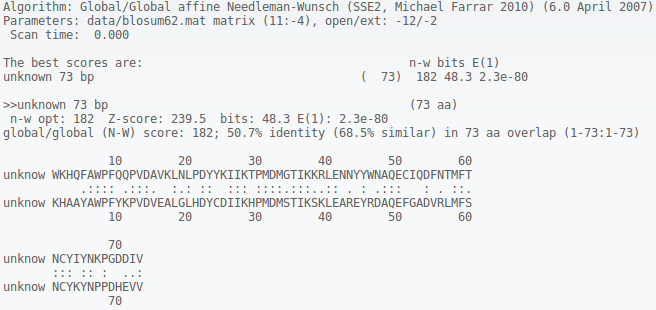

Nous pouvons constater que les résultats obtenus avec notre algorithme sont identiques à ceux de LALIGN.
En effet, nous avons utilisé la même matrice de substitution "BLOSUM62" ainsi que des pénalités de gap identiques (I = 12 et E = 2). L'algorithme utilisé par LALIGN est Needleman-Wunsch.

De plus, le taux de similitudes (68.5%) et le taux d'identité (50.7%) des 2 sont identiques.

En regardant les données de UNIPROT, nous nous aperçevons que les 2 séquences appartiennent à la même famille: un bromodomaine contenant une protéine 4. Le gène est également identique: BRD4 et les 2 sont issus d'un organisme Humain.

#### Séquence 1 et 3 du fichier BRD-sequences

In [32]:
G4 = GlobalAlignment(1, 12, 2, "blosum62.txt", P.get_seq(0), P.get_seq(2), 1)
G4.Needleman_Wunsch()

Séquence 1 de longueur 74: 
>sp|O60885|75-147

WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIV

Séquence 2 de longueur 72: 
>sp|P21675|1397-1467

RDLPNTYPFHTPVNAKVVKDYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVKNSATYNGPKHSLT

matrice de substitution utilisée: blosum62.txt
Pénalité de gap affine: I = 12 | E = 2

>>> Alignement: 
WKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFT
     ..::. ::.: :.   ::::::  :::. :........ : . .:  . .. .  
RDLPNTYPFHTPVNA-KVVK-DYYKIITRPMDLQTLRENVRKRLYPSREEFREHLELIVK


NCYIYNKPGDDIV
:   :: :  ...
NSATYNGPKHSLT


==> similarité: 61.64383561643836 %
==> Identité: 30.136986301369863 %


[61.64383561643836]

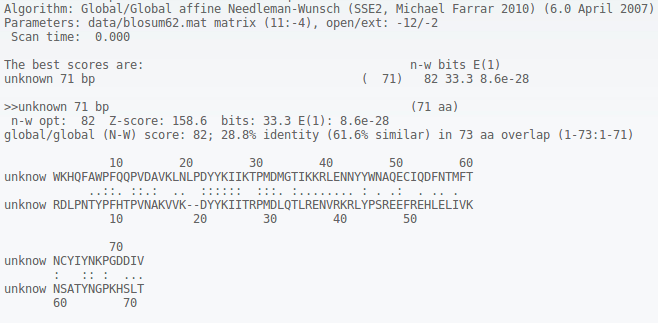

Avec ces 2 séquences (1er et 3ème du fichier BRD-sequences), nous obtenons le même résultat que LALIGN à peu de chose près. En effet, la sous séquence "KVVK" est entourée par 1 gap de chaque côté dans notre cas, tandis que d'après LALIGN, a la position 20, la sous-séquence "KVVK" est suivie de 2 gap. Cela peut être dû à la pénalité de gap affine choisie.

En regardant les données de UNIPROT, nous avons 2 séquences différentes: 
- La première séquence est un "Bromodomaine contenant une protéine 4", et de gêne BRD4
- La deuxième séquence est un "Transcription initiation factor TFIID subunit 1", et de gêne TAF1

Pourtant, ils ont un taux de similarités de 61,6 %. nous poserons l'hypothèse que ces 2 séquences d'un organisme de type Humain sont assez similaires malgré qu'ils ne soient pas de la même famille.

### Local

Afin de tester les solutions des alignements locaux, nous utiliserons également les sites "LALIGN" pour les alignements et "UNIPROT" pour les données liées au type de protéines.


#### Exemple simple
Voici un alignement local sur un exemple simple avec la matrice de substitution BLOSUM62 et une pénalité affine (  I = 4, E = 4) :

In [33]:
P2 = ParserSequence("protein-sequences.fasta")
P2.parse()

seq1 = Sequence("Séquence 1 de l'exemple","ISALIGNED")
seq2 = Sequence("Séquence 2 de l'exemple", "THISLINE")
L0 = LocalAlignment(2, 4, 4, "blosum62.txt", seq1, seq2, 2)
L0.Smith_Waterman()

Séquence 1 de longueur 10: 
Séquence 1 de l'exemple
ISALIGNED

Séquence 2 de longueur 9: 
Séquence 2 de l'exemple
THISLINE

matrice de substitution utilisée: blosum62.txt
Pénalité de gap affine: I = 4 | E = 4
la matrice de Scoring: 
*  -  I  S  A  L   I   G   N   E   D
-  0  0  0  0  0   0   0   0   0   0
T  0  0  1  0  0   0   0   0   0   0
H  0  0  0  0  0   0   0   1   0   0
I  0  4  0  0  2   4   0   0   0   0
S  0  0  8  4  0   0   4   1   0   0
L  0  2  4  7  8   4   0   1   0   0
I  0  4  0  3  9  12   8   4   0   0
N  0  0  5  1  5   8  12  14  10   6
E  0  0  1  4  1   4   8  12  19  15

mise a 0: 
*  -  I  S  A  L  I   G   N   E   D
-  0  0  0  0  0  0   0   0   0   0
T  0  0  1  0  0  0   0   0   0   0
H  0  0  0  0  0  0   0   1   0   0
I  0  0  0  0  2  4   0   0   0   0
S  0  0  0  0  0  0   4   1   0   0
L  0  2  4  7  0  4   0   1   0   0
I  0  4  0  3  9  0   0   4   0   0
N  0  0  5  1  5  8  12   0  10   6
E  0  0  1  4  1  4   8  12   0  15

recalcul de la matrice: 

[75.0, 100.0]

Comme nous pouvons le voir, cet exemple coincide avec celui présenté dans les slides du projet.

#### Séquences du fichier protein-sequences

Nous allons maintenant tester l'alignement local sur différentes séquences du fichier protein-sequence.fasta

Données de UNIPROT:

Organisme de toutes les séquences: Homo sapiens (Human)
- Séquence 1 (Q9H8M2) : 
    - proteine = Bromodomain-containing protein 9 
    - gene = BRD9
- Séquence 2 (O60885) :
    - proteine = Bromodomain-containing protein 4
    - gene = BRD4
- Séquence 3 (P21675) :
    - proteine = Transcription initiation factor TFIID subunit 1
    - gene = TAF1
- Séquence 4 (Q86U86) :
    - proteine = Protein polybromo-1
    - gene = PBRM1
- Séquence 5 (Q9NPI1):
    - proteine = Bromodomain-containing protein 7
    - gene = BRD7

#### Séquences identiques

Nous testons l'alignement local sur 2 séquences identiques :

In [34]:
L1 = LocalAlignment(1, 12, 2, "blosum62.txt", P2.get_seq(0), P2.get_seq(0), 1)
L1.Smith_Waterman()

Séquence 1 de longueur 598: 
>sp|Q9H8M2|BRD9_HUMAN Bromodomain-containing protein 9 OS=Homo sapiens OX=9606 GN=BRD9 PE=1 SV=2

MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKREREHCDTEGEADDFDPGKKVEVEPPPDRPVRACRTQPAENESTPIQQLLEHFLRQLQRKDPHGFFAFPVTDAIAPGYSMIIKHPMDFGTMKDKIVANEYKSVTEFKADFKLMCDNAMTYNRPDTVYYKLAKKILHAGFKMMSKQAALLGNEDTAVEEPVPEVVPVQVETAKKSKKPSREVISCMFEPEGNACSLTDSTAEEHVLALVEHAADEARDRINRFLPGGKMGYLKRNGDGSLLYSVVNTAEPDADEEETHPVDLSSLSSKLLPGFTTLGFKDERRNKVTFLSSATTALSMQNNSVFGDLKSDEMELLYSAYGDETGVQCALSLQEFVKDAGSYSKKVVDDLLDQITGGDHSRTLFQLKQRRNVPMKPPDEAKVGDTLGDSSSSVLEFMSMKSYPDVSVDISMLSSLGKVKKELDPDDSHLNLDETTKLLQDLHEAQAERGGSRPSSNLSSLSNASERDQHHLGSPSRLSVGEQPDVTHDPYEFLQSPEPAASAKT

Séquence 2 de longueur 598: 
>sp|Q9H8M2|BRD9_HUMAN Bromodomain-containing protein 9 OS=Homo sapiens OX=9606 GN=BRD9 PE=1 SV=2

MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKREREHCDTEGEADDFDPGKKVEVEPPPDRPVRACRTQPAENESTPIQQLLEH

[100.0]

Comme prévu, le taux de similarité est maximal étant donné qu'ils sont identiques.

#### Séquences les plus similaires parmi le fichier protein-sequences
Nous essayons à présent de déterminer les séquences du fichier protein-sequences.fasta les plus similaires avec l'alignement local :

In [35]:
def get_best_localalignments():
    best_score = [0, 0, 0] # les 2 derniers 0 accueilleront les numéros de séquences dont
                             # le score est maximal
    
    for i in range(5):
        for j in range(5):
            if i != j: # on ne compare pas une séquence avec elle-même
                #print(i, "  ", j)
                L_tmp = LocalAlignment(1, 12, 2, "blosum62.txt", P2.get_seq(i), P2.get_seq(j), 0)
                tmp_score = L_tmp.Smith_Waterman()
                if tmp_score[0] > best_score[0]:
                    best_score[0] = tmp_score[0]
                    best_score[1] = i
                    best_score[2] = j
    return best_score
#best= get_best_localalignments()

#print("le meilleur score est celui-ci: ", best[0])
#L2 = LocalAlignment(1, 12, 2, "blosum62.txt", P2.get_seq(best[1]), P2.get_seq(best[2]), 1)
#L2 = L2.Smith_Waterman()

Nous constatons que les 2 séquences ayant le taux de similarité le plus élevé, ne sont pas de la même famille :
- La première séquence est un "Transcription initiation factor TFIID subunit 1", et avec un gêne de type TAF1
- La deuxième séquence est un "bromodomaine contenant des protéines 7", avec un gêne de type BRD7

Peut-être ont-ils des fonctionnalités similaires au sein de l'organisme humain ?


#### Séquences 1 et 2 du fichier protein-sequences

In [36]:
L3 = LocalAlignment(3, 12, 2, "blosum62.txt", P2.get_seq(0), P2.get_seq(1), 1)
L3.Smith_Waterman()


Séquence 1 de longueur 598: 
>sp|Q9H8M2|BRD9_HUMAN Bromodomain-containing protein 9 OS=Homo sapiens OX=9606 GN=BRD9 PE=1 SV=2

MGKKHKKHKAEWRSSYEDYADKPLEKPLKLVLKVGGSEVTELSGSGHDSSYYDDRSDHERERHKEKKKKKKKKSEKEKHLDDEERRKRKEEKKRKREREHCDTEGEADDFDPGKKVEVEPPPDRPVRACRTQPAENESTPIQQLLEHFLRQLQRKDPHGFFAFPVTDAIAPGYSMIIKHPMDFGTMKDKIVANEYKSVTEFKADFKLMCDNAMTYNRPDTVYYKLAKKILHAGFKMMSKQAALLGNEDTAVEEPVPEVVPVQVETAKKSKKPSREVISCMFEPEGNACSLTDSTAEEHVLALVEHAADEARDRINRFLPGGKMGYLKRNGDGSLLYSVVNTAEPDADEEETHPVDLSSLSSKLLPGFTTLGFKDERRNKVTFLSSATTALSMQNNSVFGDLKSDEMELLYSAYGDETGVQCALSLQEFVKDAGSYSKKVVDDLLDQITGGDHSRTLFQLKQRRNVPMKPPDEAKVGDTLGDSSSSVLEFMSMKSYPDVSVDISMLSSLGKVKKELDPDDSHLNLDETTKLLQDLHEAQAERGGSRPSSNLSSLSNASERDQHHLGSPSRLSVGEQPDVTHDPYEFLQSPEPAASAKT

Séquence 2 de longueur 1363: 
>sp|O60885|BRD4_HUMAN Bromodomain-containing protein 4 OS=Homo sapiens OX=9606 GN=BRD4 PE=1 SV=2

MSAESGPGTRLRNLPVMGDGLETSQMSTTQAQAQPQPANAASTNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDI

[58.03108808290155, 58.71559633027523, 64.35643564356435]

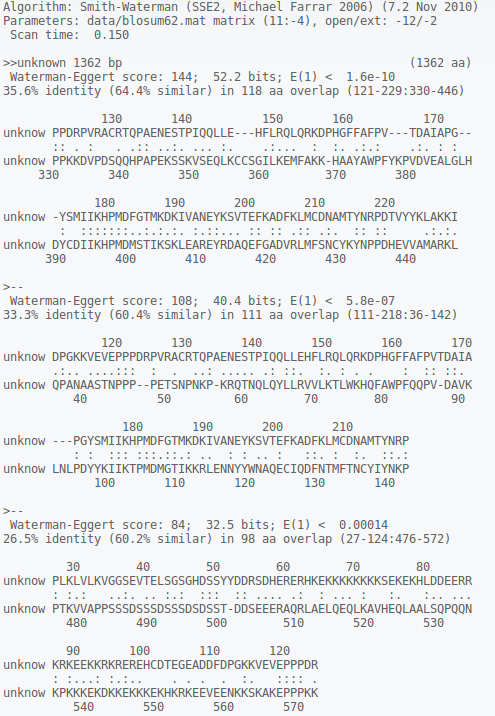

Nous constatons que les résultats ne sont pas les mêmes que ceux de LALIGN. Les 2 résultats ont par ailleurs utilisées les mêmes matrices de substitution BLOSUM62 et des pénalités de gap affine I = 12 et E = 2

Notre alignement contient le sous alignement que nous donnes LALIGN. Par exemple, Notre première solution part de "PPDR" et finit en "ALVE" tandis que la première solution de LALIGN s'arrête bien avant en "AKKI". La position des gap change également. Par exemple, après la section 160 de la première solution, nous constatons que le V est suivi de 3 gaps dans LALIGN tandis que notre V est précédé de plusieurs gap.

La 3ème solution par contre, est identique à celle de LALIGN à peu près. Dans celui-ci, aucun gap n'a été introduit du côté de LALIGN et 2 sont apparus dans notre solution.

D'après les données d'UNIPROT, ces 2 séquences sont des bromodomaines mais contenant des protéines de type différentes (9 pour la première et 4 pour la deuxième. Ces séquences sont donc relativement similaires.

## Conclusion

Pour conclure, notre problème était d'aligner des séquences d'acides aminés de sorte à trouver leurs similitudes maximales dissimulées et déterminer si celles-ci sont homologues (2 gènes ou 2 protéines qui partagent un ancêtre commun). Pour ce faire, nous avons utilisé les algorithmes de Needleman-Wunsch et Smith-Waterman pour les alignements globaux et locaux. 

Nous avons constaté que fatalement, lorsque 2 séquences appartiennent à la même famille (2 bromodomaines contenant des protéines 4 par exemple) ainsi que la meme gêne, l'alignement global ou local donnait un taux de similarité elevé. D'autre part, certains alignements concernaient 2 séquences n'étant pas de la même famille. Le taux de similarités était tout de même élevé, ce qui laisse croire qu'ils ont des fonctionnalités similaires. 

